# Project 3: 'Image Analysis'
## First Year Project  
### ITU, Spring 2021

This notebook contains all the code developed to explore, wrangle and analyse the raw data sets for our project, 'Image Analysis'.

Contributors:  
- Andy Bao Nguyen (anbn)
- Florian Micliuc (flmi)
- Mattias Wohlert 
- Sofia Elena Terenziani (sote)

Created: 06-04-2021 

Last modified:

### Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import matplotlib.cm as cm
from skimage import morphology
from scipy.spatial.distance import cdist
from scipy.stats.stats import mode
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score

# Loading of data and scripts

In [3]:
%run ../Scripts/fyp2021p3_group00_functions.py

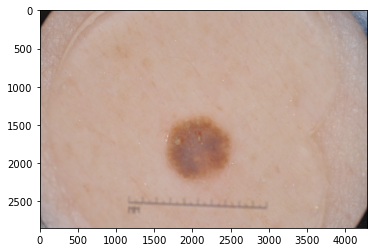

In [4]:
im = plt.imread("../Data/Raw/example_image/ISIC_0014310.jpg")
plt.imshow(im)